Using the Credit Card Fraud Detection dataset from kaggle
to train a pyspark Logistic Regression Model, logging in it to MLFlow.

Data corresponds to anonymized credit card transactions labeled as fraudulent or genuine.

Available at
www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import pyspark #
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression as LogisticRegressionPySpark
import pyspark.sql.functions as F

import sklearn #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

from IPython.display import Image, display, Markdown     
from IPython.core.display import HTML                    
#Display the dataframe in table format
display(HTML("<style = fonte-size>pre { white-space: pre !important; }</style>"))

CPU times: user 2.48 s, sys: 141 ms, total: 2.62 s
Wall time: 2.65 s


# Creating a spark session

In [2]:
%%time
os.environ["SPARK_LOCAL_IP"]='127.0.0.1'
spark = SparkSession.builder.master("local[*]").getOrCreate()
conf = spark.sparkContext._conf.getAll()

23/04/16 01:02:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


CPU times: user 46.2 ms, sys: 21.4 ms, total: 67.6 ms
Wall time: 7.39 s


# Loading the dataset

In [3]:
%%time
data_path = 'creditcard.csv'
df = spark.read.csv(data_path, header = True, inferSchema = True)
labelColumn = "Class"
columns = df.columns
numericCols = columns
numericCols.remove(labelColumn)
print(numericCols)
aux = df.toPandas()
aux.head()

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


23/04/16 01:02:43 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


CPU times: user 6.89 s, sys: 547 ms, total: 7.44 s
Wall time: 23.8 s


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Getting columns' description

In [4]:
%%time
print(f'Number of rows: {aux.shape[0]} Number of columns: {aux.shape[1]}')
aux.describe()

Number of rows: 284807 Number of columns: 31
CPU times: user 479 ms, sys: 4.04 ms, total: 484 ms
Wall time: 480 ms


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.958151e-16,-3.147640e-15,1.772925e-15,...,1.471982e-16,8.042109e-16,5.282450e-16,4.458267e-15,1.426896e-15,1.701640e-15,-3.671606e-16,-1.218152e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Splitting dataframe by Class and Selecting columns for the 'features' vector

In [5]:
%%time
#inputs to the assembler, columns to transform into the features vector.
dfFeatures = df.select(F.col(labelColumn).alias('label'),*numericCols )


normal = dfFeatures.filter("Class == 0").sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = dfFeatures.filter("Class == 1")

#80-20 split between the training and testing data
normal_train, normal_test = normal.randomSplit([0.8, 0.2],seed = 2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2],seed = 2020)

#Combining normal and anomaly splits to form the training and testing sets. 
train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

print("Training Dataset Count: ", train.count())
print("Test Dataset Count: ", test.count())

Training Dataset Count:  114125


[Stage 5:=============================>                             (4 + 4) / 8]

Test Dataset Count:  28611
CPU times: user 51.9 ms, sys: 9.3 ms, total: 61.2 ms
Wall time: 17.9 s


# Building the training pipeline

In [6]:
%%time

stages = []
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages = stages)
#creating the features vector
pipelineModel = pipeline.fit(dfFeatures)
train = pipelineModel.transform(train)
test = pipelineModel.transform(test)


selectedCols = ['label', 'features'] + numericCols
train = train.select(selectedCols)
test = test.select(selectedCols)

print('training set rows',train.count())
print('test set rows',test.count())

training set rows 114125


[Stage 9:============================================>              (6 + 2) / 8]

test set rows 28611
CPU times: user 92.8 ms, sys: 24.1 ms, total: 117 ms
Wall time: 13.9 s


# Model training

In [7]:
%%time
lr = LogisticRegressionPySpark(featuresCol = 'features',labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
pyspark_auc_score = trainingSummary.areaUnderROC

23/04/16 01:03:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/16 01:03:40 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


CPU times: user 55.6 ms, sys: 9.65 ms, total: 65.2 ms
Wall time: 24.6 s


# Model Evaluation

In [8]:
%%time
predictions = lrModel.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
evaluations = lrModel.evaluate(test)
accuracy = evaluations.accuracy

print(f"AUC Score: {roc_auc_score(y_pred, y_true):.3%}")
print(f"PySpark AUC Score: {pyspark_auc_score:.3%}")
print(f"Accuracy Score: {accuracy:.3%}")

AUC Score: 95.635%
PySpark AUC Score: 97.991%
Accuracy Score: 99.888%
CPU times: user 2.72 s, sys: 15.6 ms, total: 2.74 s
Wall time: 29.5 s


CPU times: user 68.6 ms, sys: 3.76 ms, total: 72.4 ms
Wall time: 420 ms


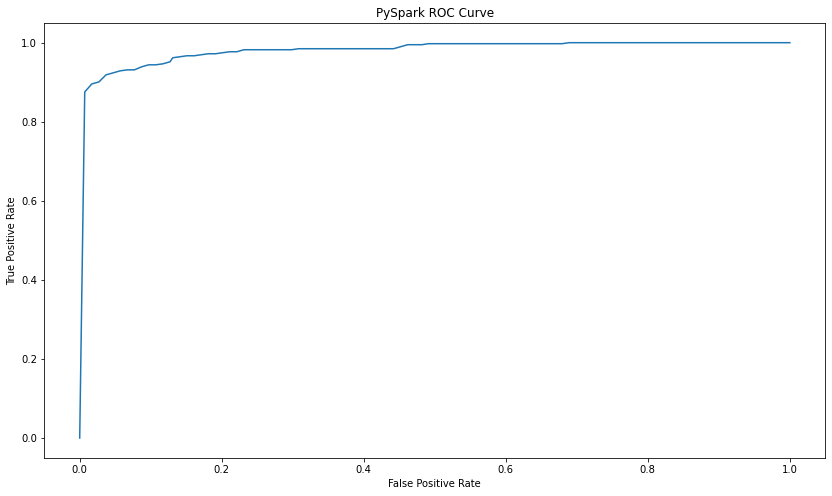

In [9]:
%%time
#Looking at the ROC curve
pyspark_roc = trainingSummary.roc.toPandas()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PySpark ROC Curve')
plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])

CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.22 s


Text(0.5, 51.0, 'Predicted')

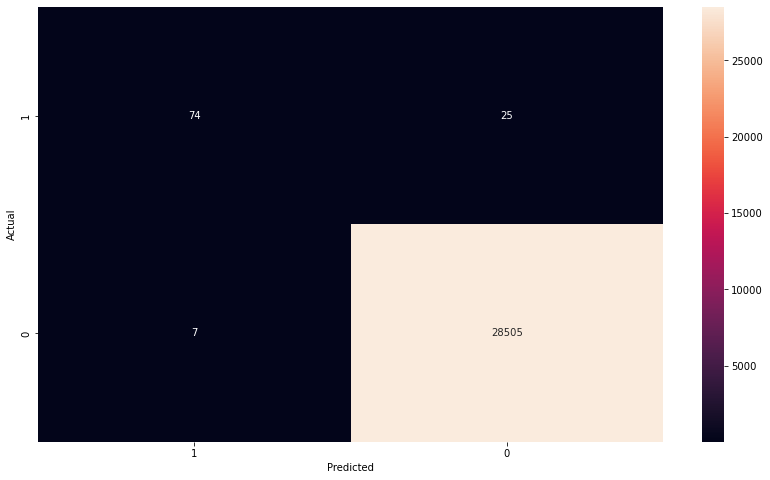

In [10]:
%%time
#confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')
#the model has a 74.75 % (74/74+25) accuracy in predicting anomalies

# MLFlow with PySpark

In [11]:
import mlflow
import mlflow.spark
print(mlflow.__version__)

1.30.1


In [12]:
#Defining a function to train the model and calculate some relevant metrics
def train_(spark_model, train_set):
    trained_model = spark_model.fit(train_set)
    trainingSummary = trained_model.summary
    pyspark_auc_score = trainingSummary.areaUnderROC
    mlflow.log_metric("train_acc", trainingSummary.accuracy)
    mlflow.log_metric("train_AUC", pyspark_auc_score)
    print("Training Accuracy: ", trainingSummary.accuracy)
    print("Training AUC:", pyspark_auc_score)

    #Looking at the ROC curve
    pyspark_roc = trainingSummary.roc.toPandas()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('PySpark ROC Curve')
    plt.plot(pyspark_roc['FPR'],pyspark_roc['TPR'])    
    plt.savefig("pyspark_roc_plot.png")
    plt.clf()
    
    mlflow.log_artifact("pyspark_roc_plot.png")
      
    return trained_model
#function for evaluating the model and calculating some metrics
def evaluate_(spark_model, test_set):
    evaluation_summary = spark_model.evaluate(test_set)
    eval_acc = evaluation_summary.accuracy
    eval_AUC = evaluation_summary.areaUnderROC
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("eval_AUC", eval_AUC)
    print("Evaluation Accuracy: ", eval_acc)
    print("Evaluation AUC: ", eval_AUC)
    
    predictions = spark_model.transform(test_set)
    y_true = predictions.select(['label']).collect()
    y_pred = predictions.select(['prediction']).collect()  
    
    #confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted') 
    
    plt.title("Confusion Matrix")
    plt.savefig("pyspark_conf_matrix.png")  
    plt.clf()
    
    mlflow.log_artifact("pyspark_conf_matrix.png")

# Building the model and logging into mlflow

In [13]:
%%time
lr = LogisticRegressionPySpark(featuresCol = 'features', labelCol ='label', maxIter=10)

mlflow.set_experiment("PySpark_CreditCard")

with mlflow.start_run():
    trainedLR = train_(lr, train)
    evaluate_(trainedLR, test)
    mlflow.spark.log_model(trainedLR, "creditcard_model_pyspark")
    print("Model run: ", mlflow.active_run().info.run_uuid)
mlflow.end_run()


Training Accuracy:  0.9986243154435925
Training AUC: 0.979941282434515


Evaluation Accuracy:  0.9988815490545594
Evaluation AUC:  0.9771588287476336


Model run:  3cc3a8c63a82405aa080a12c06fec686
CPU times: user 5.59 s, sys: 204 ms, total: 5.8 s
Wall time: 1min 21s


<Figure size 1008x576 with 0 Axes>

Now we can open the MLFlow UI (mlflow ui -p 1234),
observing the following result

![MLFlow UI](images/mlflow_ui2.png)

# Loading a model saved in mlflow UI

In [14]:
%%time
YOUR_RUN_ID = '69d50209a88d4cc9b51c7284e2fdacd4'
model = mlflow.spark.load_model(f"runs:/{YOUR_RUN_ID}/creditcard_model_pyspark")
type(model)

2023/04/16 01:05:51 INFO mlflow.spark: 'runs:/69d50209a88d4cc9b51c7284e2fdacd4/creditcard_model_pyspark' resolved as 'file:///home/tumbarell/Escritorio/mlflow/MLFlow_with_pyspark/mlruns/1/69d50209a88d4cc9b51c7284e2fdacd4/artifacts/creditcard_model_pyspark'
2023/04/16 01:05:51 INFO mlflow.spark: File 'file:///home/tumbarell/Escritorio/mlflow/MLFlow_with_pyspark/mlruns/1/69d50209a88d4cc9b51c7284e2fdacd4/artifacts/creditcard_model_pyspark/sparkml' is already on DFS, copy is not necessary.


CPU times: user 59.7 ms, sys: 30.9 ms, total: 90.6 ms
Wall time: 2.06 s


pyspark.ml.pipeline.PipelineModel

In [15]:
%%time
from sklearn.metrics import accuracy_score
#making some predictions with the loaded model
predictions = model.transform(test)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

print(f"AUC Score: {roc_auc_score(y_true, y_pred):.3%}")
print(f"Accuracy Score: {accuracy_score(y_true, y_pred):.3%}")

AUC Score: 87.361%
Accuracy Score: 99.888%
CPU times: user 6.74 s, sys: 32.9 ms, total: 6.77 s
Wall time: 18.6 s


CPU times: user 3.91 s, sys: 3.94 ms, total: 3.92 s
Wall time: 3.92 s


Text(0.5, 51.0, 'Predicted')

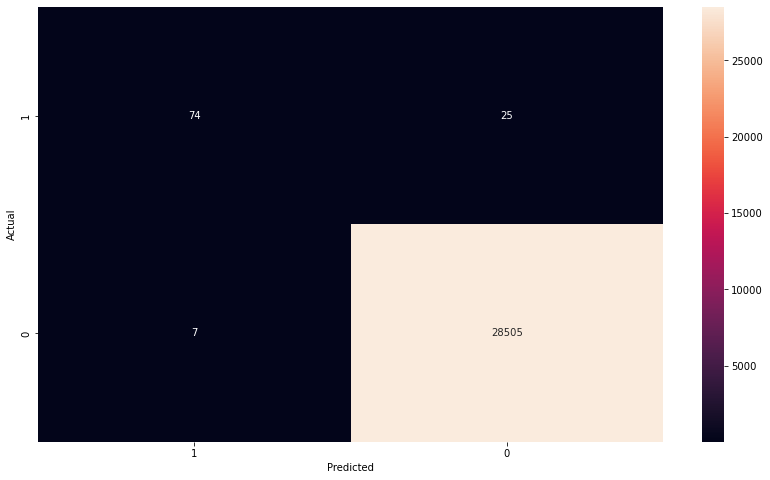

In [16]:
%%time
conf_matrix = confusion_matrix(y_true, y_pred)
ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')